In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h1> Data preprocessing </h1>

In [0]:
path = '/content/drive/My Drive/CONLL03/'

train = open(path+'eng_train.txt', 'r').read()
test = open(path+'eng_testb.txt', 'r').read()
train = train.splitlines()
test = test.splitlines()

In [0]:
# Define features to be used by the CRF model

def feat_extract(sent):

  sent_feat = []

  for i in range(len(sent)):
    if i == 0:
      features = {
        'word': sent[i][0].lower(),
        'capital_let': sent[i][0][0].isupper(),
        'word.isdigit()': sent[i][0].isdigit(),
        'pos_tag': sent[i][1],
        'chunk_tag': sent[i][2],
        'word_before': '',
        'word_after':  '' if len(sent)==1 else sent[i+1][0].lower(),
        'BOS': True,
        'EOS': False
      }
    elif i == len(sent)-1:
      features = {
        'word': sent[i][0].lower(),
        'capital_let': sent[i][0][0].isupper(),
        'word.isdigit()': sent[i][0].isdigit(),
        'pos_tag': sent[i][1],
        'chunk_tag': sent[i][2],
        'word_before': sent[i-1][0].lower(),
        'word_after': '',
        'BOS': False,
        'EOS': True
      }
    else:
      features = {
        'word': sent[i][0].lower(),
        'capital_let': sent[i][0][0].isupper(),
        'word.isdigit()': sent[i][0].isdigit(),
        'pos_tag': sent[i][1],
        'chunk_tag': sent[i][2],
        'word_before': sent[i-1][0].lower(),
        'word_after': sent[i+1][0].lower(),
        'BOS': False,
        'EOS': False
      }
    sent_feat.append(features)

  return sent_feat

In [0]:
# Create a list containing lists of feature dicts for each sentence
def list_features(arq):
  ans = []
  sentence = []
  for i in range(len(arq)):
    if len(arq[i].split()) < 3 or i == len(arq)-1:
      ans.append(feat_extract(sentence))
      sentence = []
    else:
      sentence.append(arq[i].split())
  return ans

# Create lists for labels of each sentence
def list_labels(arq):
  ans = []
  sent_labels = []
  for i in range(len(arq)):
    if len(arq[i].split()) < 3 or i==len(arq)-1:
      ans.append(sent_labels)
      sent_labels = []
    else:
      sent_labels.append(arq[i].split()[3])
  return ans

In [0]:
# Create lists of features (dictionaries of features) for each sentence
unlabeled_x = list_features(train)
x_test = list_features(test)

# Create list of labels for each sentence
unlabeled_y = list_labels(train)
y_test = list_labels(test)


<h2> CRF-suite from sklearn </h2>

In [27]:
!pip install sklearn-crfsuite

import sklearn_crfsuite
from sklearn_crfsuite import metrics

In [0]:
# Defining CRF model
model = sklearn_crfsuite.CRF(
    algorithm = 'l2sgd', 
    c2=1,
    max_iterations=100, 
    all_possible_transitions=True,
    verbose=False
)

<h1> Active learning algorithm </h1>


<h3> Sampling and utility functions </h3>

In [0]:
from math import floor
from random import sample

# Least confidence sampling function (Computed on the sequence of labels chosen by the CRF)
"""def least_confidence(model, unlabeled_x):
  min_prob = 1
  idx = -1
  if not unlabeled_x:
    return -1
  for i in range(len(unlabeled_x)):
    aux = get_confidence(model, unlabeled_x[i])
    if aux < min_prob:
      idx = i
      min_prob = aux
  return idx"""
def least_confidence(model, unlabeled_x, batch_sample_size):
  # List containing (index, confidence) pairs
  idx_conf = []
  if not unlabeled_x:
    return -1
  for i in range(len(unlabeled_x)):
    idx_conf.append([i, get_confidence(model, unlabeled_x[i])])
  idx_conf.sort(key=lambda x: x[1])
  return [idx_conf[i][0] for i in range(min(len(unlabeled_x), batch_sample_size))]

# Helper function for the least confidence function (returns the probability of the chosen sentence sent)
def get_confidence(model, sent):
  # marg_prob = model.predict_marginals_single(sent)
  # predict_labels = model.predict_single(sent)
  # prob = 1
  # for i in range(len(predict_labels)):
  #   prob *= marg_prob[i][predict_labels[i]]
  # return prob
  aux = model.tagger_.tag(sent)
  return model.tagger_.probability(aux)

# Random sampling function
"""def random_sampling(unlabeled_x):
  if not unlabeled_x:
    return -1
  else:
    return randint(0, len(unlabeled_x)-1)"""
def random_sampling(unlabeled_x, batch_sample_size):
  if not unlabeled_x:
    return -1
  else:
    return sample(range(min(len(unlabeled_x), batch_sample_size)), min(len(unlabeled_x), batch_sample_size))

# Take sample from unlabeled set and add to labeled set from index idx
"""def switch_sets(idx, unlabeled_x, unlabeled_y, labeled_x, labeled_y):
  labeled_x.append(unlabeled_x[idx])
  labeled_y.append(unlabeled_y[idx])
  del unlabeled_x[idx]
  del unlabeled_y[idx]"""
def switch_sets(idx, unlabeled_x, unlabeled_y, labeled_x, labeled_y):
  idx.sort(reverse = True)
  for i in idx:
    labeled_x.append(unlabeled_x[i])
    labeled_y.append(unlabeled_y[i])
    del unlabeled_x[i]
    del unlabeled_y[i]


# Function to evaluate the model on test set / Code taken from "https://github.com/TeamHG-Memex/sklearn-crfsuite/blob/master/docs/CoNLL2002.ipynb" (Turned into function)
def eval(crf, x_test, y_test, labels):
  y_pred = crf.predict(x_test)
  return metrics.flat_f1_score(y_test, y_pred, 
                      average='weighted', labels=labels)

# Function to extract label set from training set / Code taken from "https://github.com/TeamHG-Memex/sklearn-crfsuite/blob/master/docs/CoNLL2002.ipynb" (Turned into function) 
def model_labels(model):
  labels = list(model.classes_)
  labels.remove('O')
  return labels

import matplotlib.pyplot as plt

<h3> Creating the initial labeled set </h3>

In [30]:


# Initial labeled set size (percentage >=0 and <=1)
labeled_set_size = 0.2
train_set_size = len(unlabeled_x)

# Define labeled set
labeled_x = []
labeled_y = []

"""for i in range(floor(labeled_set_size * train_set_size)):
  idx = random_sampling(unlabeled_x)
  switch_sets(idx, unlabeled_x, unlabeled_y, labeled_x, labeled_y)"""
idx = random_sampling(unlabeled_x, floor(labeled_set_size * train_set_size))
switch_sets(idx, unlabeled_x, unlabeled_y, labeled_x, labeled_y)

print(len(labeled_x), len(labeled_y))
print(len(unlabeled_x), len(unlabeled_y))

2997 2997
11990 11990


<h3> Active learning loop </h3>

In [0]:
# Define number of iterations (Active learning iterations)
iterations = 100
# Define number of queries to be made per iteration
batch_sample_size = 150

# List to save model performance history throughout AL training
hist = []
# List to save percentage of original training set labeled
labeled_size = []

# Train initial model
model.fit(labeled_x, labeled_y)

# Get set of labels except for "O"
labels = model_labels(model)

labeled_size.append(len(labeled_x)/train_set_size)
hist.append(eval(model, x_test, y_test, labels))

for iter in range(iterations):
  # print("Iterations:", iter)
  # idx = least_confidence(model, unlabeled_x, batch_sample_size)
  idx = random_sampling(unlabeled_x, batch_sample_size)
  if idx == -1:
    break
  switch_sets(idx, unlabeled_x, unlabeled_y, labeled_x, labeled_y)
  model.fit(labeled_x, labeled_y)
  hist.append(eval(model, x_test, y_test, labels))
  labeled_size.append(len(labeled_x)/train_set_size)
  if not unlabeled_x:
    break


Text(0, 0.5, 'F1-score')

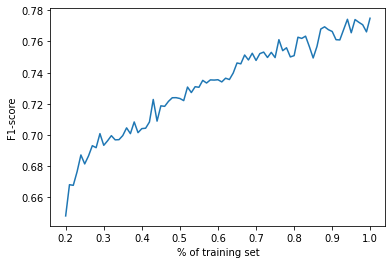

In [32]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.plot(labeled_size, hist)
# plt.plot(labeled_size, LC_hist, 'r--')
# plt.plot(labeled_size, rand_hist, 'b--')
plt.xlabel('% of training set')
plt.ylabel('F1-score')
# red_patch = mpatches.Patch(color='red', label='LC')
# blue_patch = mpatches.Patch(color='blue', label='RAND')
# plt.legend(handles=[red_patch, blue_patch])


In [0]:
# LC = hist
RAND = hist

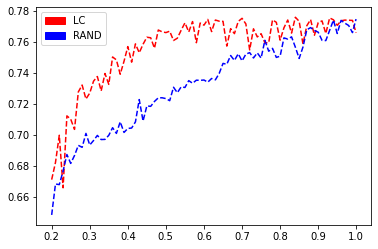

In [34]:
plt.plot(labeled_size, LC, 'r--')
plt.plot(labeled_size, RAND, 'b--')
red_patch = mpatches.Patch(color='red', label='LC')
blue_patch = mpatches.Patch(color='blue', label='RAND')
plt.legend(handles=[red_patch, blue_patch])